In [171]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'xtick.labelsize': 18})





In [172]:
# policy colors
# https://coolors.co/palette/fa686a-ff8352-fecb02-57c78b-71d6ca-4d9de0-7776bc-fec1c9
# Base - C0 (blue)
# fed - C1 (orange)
# eb - C2 (green)
# roundrobin - C3
# rtime - C4
# central - C5
# hybrid - C6
# Oracle - C7

polcols = {
'ORACLE':'C7',
'ROUNDROBIN':'C3',
'CENTRALIZED':'C5',
'HYBRID':'C6',
'RTIME':'C4',
'EPOCH_CENTRAL':'C2',
'RANDOM':'C1',
}

polcols2 = {'roundrobin':'C3'
            ,'federated':'C1'
            , 'roundrobinlatency':'C4'
            , 'base':'C0'
            , 'epoch':'C2'}


pallete = {
'DECENTRALIZED' : '#fa686a',
'ROUNDROBIN'    : '#ff8352',
'CENTRALIZED'   : '#fecb02',
'HYBRID'        : '#57c78b',
'RTIME'         : '#71d6ca',
'EPOCH_CENTRAL' : '#4d9de0',
'RANDOM'        : '#7776bc',
'ORACLE'        : '#fec1c9'
}


hatches = {
'DECENTRALIZED' :'' ,
'ROUNDROBIN'    :'\\',
'CENTRALIZED'   :'/' ,
'HYBRID'        :'-' ,
'RTIME'         :'.' ,
'EPOCH_CENTRAL' :'x' ,
'RANDOM'        :'*' ,
'ORACLE'        :'O' ,
} 
markers = {
'DECENTRALIZED' : "o",
'ROUNDROBIN'    : "v",
'CENTRALIZED'   : "^",
'HYBRID'        : "<",
'RTIME'         : ">",
'EPOCH_CENTRAL' : "s",
'RANDOM'        : "*",
'ORACLE'        : "P"
}


In [2]:
## preprocessing functions
def visualize_rate(filename, ax):
    s1 = np.load(filename)
    df1 = pd.DataFrame()
    df1[0] = pd.to_datetime(s1.cumsum(), unit='s')
    df1 = df1.set_index(0)
    df1[1] = np.ones(len(df1))
    df1[1].rolling('1s').count().plot(ax=ax)

def plot_cdf(xvals, ax, **kwargs):
    x = np.sort(xvals)
    y = np.arange(len(x))/float(len(x))
    ax.plot(x,y, **kwargs)



# Motivation
---
## SF Cabs request arrival analysis

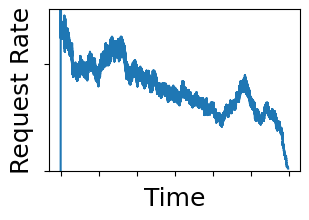

In [42]:
# fig,axs = plt.subplots(3,1, sharex=True, figsize=(3,8))
fig, ax = plt.subplots(figsize=(4,3))

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%H:%M      ')
for i in [0]:
    visualize_rate(f'../loadgen/sfcabs-12-node-load/sfcabs-load-site{9+i}.npy',ax)
    ax.set_xlabel('')
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()
# ax.legend(['1','2','3'], title='Edge Site', bbox_to_anchor=(1.1,1))
ax.set_ylabel('Request Rate', fontsize=18)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylim(0,760)
ax.set_xticklabels([])
ax.set_yticklabels([])


fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/varloads_1.pdf', bbox_inches='tight')

# Simulation
---

In [180]:
class LoadData:
    def __init__(self):
        self.ingress_clients     = None
        self.ingress_offloaded   = None
        self.total_executed      = None
        self.total_offloaded_out = None
        self.exec_latency        = None
        self.e2e_latency         = None
        self.offload_only_e2e_latency         = None
        self.local_e2e_latency         = None
        self.end_time            = None
        self.faas_count          = None

def load_data(filename):
    ometrics = {}
    with open(filename) as fh:
        ometrics = json.load(fh)
    data = LoadData()
    data.ingress_clients     = ometrics["ingress_clients"]
    data.ingress_offloaded   = ometrics["ingress_offloaded"]
    data.total_executed      = ometrics["total_executed"]
    data.total_offloaded_out = ometrics["total_offloaded_out"]
    data.exec_latency        = ometrics["exec_latency"]
    data.e2e_latency         = ometrics["e2e_latency"]
    data.end_time            = ometrics["end_time"]
    data.faas_count          = ometrics["faas_count"]
    data.offload_only_e2e_latency         = ometrics["offload_only_e2e_latency"]
    data.local_e2e_latency         = ometrics["local_e2e_latency"]
    return data

def parse_result(pol, profile, root=None):
#     root = f'/Users/anirudh/Workspace/fededge/paper/results/simulation/results/{pol}/{profile}/output_metrics.json'
    if root == None:
        root = f'/Users/anirudh/Workspace/fededge/paper/results/simulation/results3/{pol}/{profile}/output_metrics.json'

    data = load_data(root)
    lats = {}
    for tag in ['all','local','offload']:
        lats[tag] = np.array([])
#     print(data.faas_count)
    for node in range(data.faas_count):

        lats['all'] = np.concatenate((lats['all'], data.e2e_latency[node][1]))
        lats['local'] = np.concatenate((lats['local'], data.local_e2e_latency[node][1]))
        lats['offload'] = np.concatenate((lats['offload'], data.offload_only_e2e_latency[node][1]))
    no = len(lats['offload'])
    na = len(lats['all'])
#     print(pol, 100*no/na)
    return lats

def group_by_pctls(lats, pctls):
    xvals = []
    for pctl in pctls:
        xvals.append(np.percentile(lats, pctl))
    return xvals

    
def plot_sim_bar(profile, ax, **kwargs):
    root = '../faas-sim/results/{}/{}/output_metrics.json'
    pctls = [50,90,99]
    
    if 'title' in kwargs:
        title = kwargs.pop('title')
        ax.set_title(title)
    if 'pols' in kwargs:
        pols = kwargs.pop('pols')
    if 'w' in kwargs:
        w = kwargs.pop('w')
        
    xvals = np.arange(0,4*len(pctls),4)
    xticks = xvals+1.4
    for pol in pols:
        lats = parse_result(pol, profile, root.format(pol, profile))
        # convert to ms
        lats_ms = 1000*lats['all']


        new_yvals = group_by_pctls(lats_ms,pctls)
#         print(pol, new_yvals)
        ax.bar(xvals, new_yvals, color=pallete[pol], edgecolor='black', hatch=hatches[pol], width=w, **kwargs)
        xvals = xvals + w

    ax.set_xticks(xticks)
    ax.set_xticklabels(pctls)
    
def plot_per_profile(profile, ax, **kwargs):
    root = '../faas-sim/results/{}/{}/output_metrics.json'
    pctls = [50,90,95,99,99.9]
    title = kwargs.pop('title')
    pols = kwargs.pop('pols')

    for pol in pols:
        lats = parse_result(pol, profile, root.format(pol, profile))
        # convert to ms
        xvals = 1000*lats['all']

        new_xvals = group_by_pctls(xvals,pctls)
        ax.plot(new_xvals, color=pallete[pol], marker=markers[pol], **kwargs)
        ax.set_xticks(np.arange(len(pctls)))
        ax.set_xticklabels(pctls)
        ax.set_title(title)


    
pols = [
'DECENTRALIZED',
'ROUNDROBIN',
'CENTRALIZED',
'HYBRID',
'RTIME',
# 'EPOCH_CENTRAL',
'RANDOM',
'ORACLE',
]

pollabs = [
'no-offload',
'$rr$',
'$central$',
'$hybrid$',
'$rtime$',
# '$epoch$',
'$federated$',
'$state$-$aware$',
]


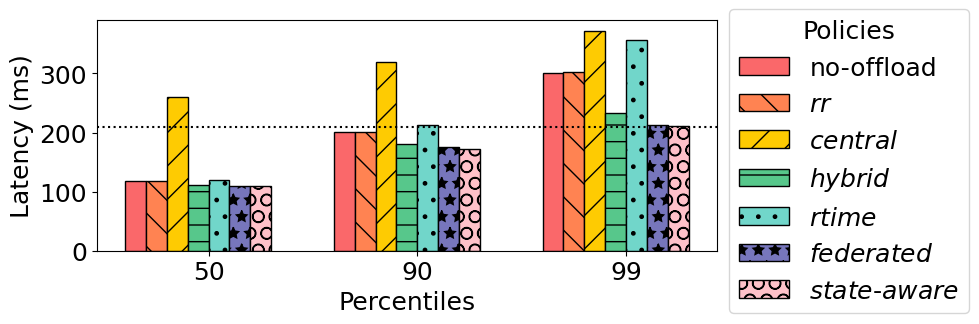

In [181]:
fig,ax = plt.subplots(figsize=(8,3))


plot_sim_bar(f"sfcab9", ax, pols=pols,w=0.4)

ax.legend(pollabs,loc=0, title='Policies', bbox_to_anchor=(1,1.1))
# ax.set_ylim((0,250))
ax.set_ylabel('Latency (ms)', fontsize=18)#'$^*$)')
ax.set_xlabel('Percentiles', fontsize=18)
ax.axhline(y=210, linestyle=':', color='black')
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-eval-1.pdf',bbox_inches='tight')


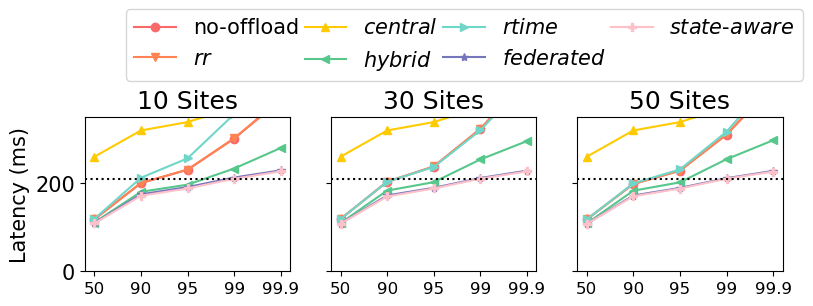

In [34]:

fig, axs = plt.subplots(1,3, figsize=(9,2), sharey=True)

# pctls = [50,90, 99,99.9]
plot_per_profile(f"sfcab9", axs[0], pols=pols, title="10 Sites")
plot_per_profile(f"sfcab_30nodes", axs[1], pols=pols, title="30 Sites")
plot_per_profile(f"sfcab_50nodes", axs[2], pols=pols, title="50 Sites")


axs[1].legend(pollabs, ncol=4, bbox_to_anchor=(-1.0,-0.3,3.3,2.0),loc=1, mode='expand', borderaxespad=0.)
axs[1].set_ylim((0,350))

# axs[1].set_xlabel('Percentiles')
axs[0].set_ylabel('Latency (ms)')
for ax in axs.flat:
    ax.axhline(y=210, linestyle=':', color='black')

fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-sitecount-eval-new.pdf',bbox_inches='tight')


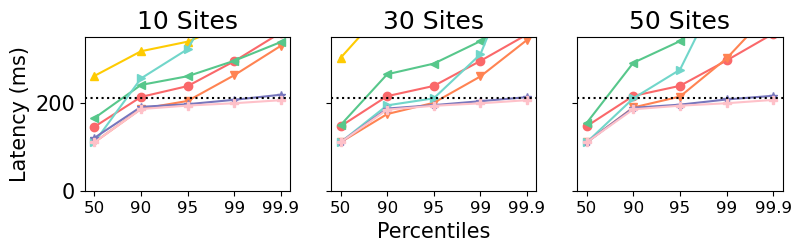

In [32]:

fig, axs = plt.subplots(1,3, figsize=(9,2), sharey=True)

# pctls = [50,90, 99,99.9]
plot_per_profile(f"10node-load1", axs[0], pols=pols, title="10 Sites")
plot_per_profile(f"30node-load1", axs[1], pols=pols, title="30 Sites")
plot_per_profile(f"50node-load1", axs[2], pols=pols, title="50 Sites")


# axs[1].legend(pollabs, ncol=4, bbox_to_anchor=(-1.0,-0.3,3.1,2.0),loc=1, mode='expand', borderaxespad=0.)
axs[1].set_ylim((0,350))
# axs[1].set_yscale('log')
axs[1].set_xlabel('Percentiles')
axs[0].set_ylabel('Latency (ms)')
for ax in axs.flat:
    ax.axhline(y=210, linestyle=':', color='black')

fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-sitecount-eval.pdf',bbox_inches='tight')



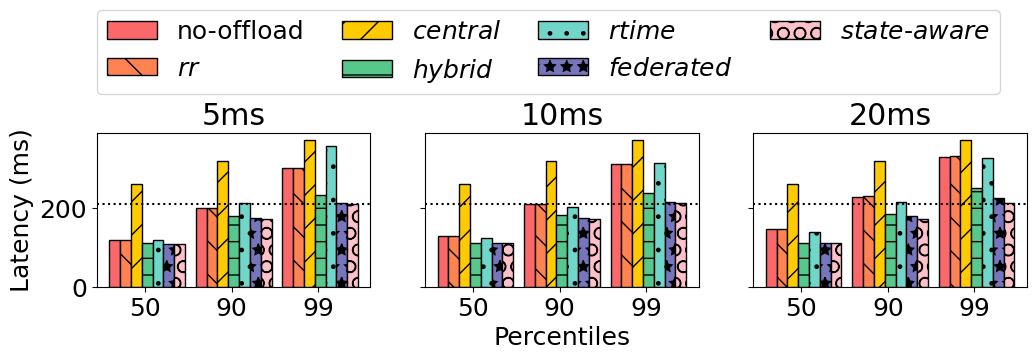

In [186]:
fig, axs = plt.subplots(1,3, figsize=(12,2), sharey=True)

# pctls = [50,90,95,99,99.9]
w=0.5
plot_sim_bar(f"sfcab9", axs[0], pols=pols, title="5ms",w=w)
plot_sim_bar(f"sfcab9-10ms", axs[1], pols=pols, title="10ms",w=w)
plot_sim_bar(f"sfcab9-20ms", axs[2], pols=pols, title="20ms",w=w)


axs[1].legend(pollabs, ncol=4, bbox_to_anchor=(-1.2,-0.2,3.3,2.0),loc=1, mode='expand', borderaxespad=0.)
# axs[1].set_ylim((0,250))
for ax in axs.flat:
    ax.axhline(y=210, linestyle=':', color='black')
    
axs[1].set_xlabel('Percentiles')
axs[0].set_ylabel('Latency (ms)')
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/simu-peerlats-eval-new.pdf',bbox_inches='tight')


# Microbenchmarks
---

In [87]:
def get_box(fn, **kwargs):
    df = pd.read_csv(fn, header=None)
    df['float_lat'] = df[0].apply(conv)
    return df['float_lat']

def conv(s):
    idx = -1
    for i,c in enumerate(s):
        if c!='.' and not c.isnumeric():
            idx = i
            break
    unit = s[idx:].strip()
    num = float(s[:idx])
    if unit =='s':
        num=num*1000

    return num

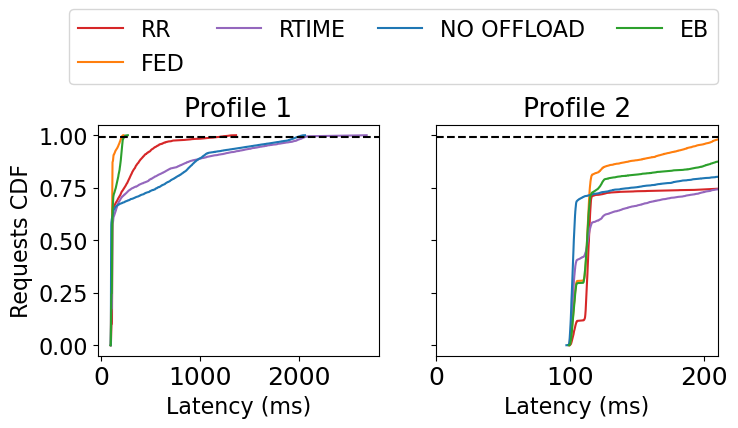

In [139]:
pols = ['roundrobin','federated', 'roundrobinlatency', 'base', 'epoch']
pollabs = ['RR', 'FED', 'RTIME', 'NO OFFLOAD', 'EB']
fig,axs = plt.subplots(1,2, sharey=True, figsize=(8,3))

sites = range(10)
sites_w_load = [0,1]
ax =axs[0]
ax.set_title('Profile 1')
for pol in pols:
    total = []
    for i in sites:
        if i in sites_w_load:
            box = get_box(f'./microbenchmark-data/10node/1node_8rps_0.6lam_3node_8rps_0.2lam/cluster_exp_fiblocal_p70_multiskew_policy_{pol}/run_load/{pol}/clabcl{i}/fiblocal-profile70-p2p20ms.out')
            total = np.concatenate((total, box))
    
    plot_cdf(total, ax, color=polcols2[pol])
#     ax.set_xlim(0,210)

    
    
ax =axs[1]
ax.set_title('Profile 2')
for pol in pols:
    total = []
    for i in sites:
        if i in sites_w_load:
            box = get_box(f'./microbenchmark-data/10node/4node_8rps_0.5lam/cluster_exp_fiblocal_p68_multiskew_policy_{pol}/run_load/{pol}/clabcl{i}/fiblocal-profile68-p2p20ms.out')
            total = np.concatenate((total, box))
    
    plot_cdf(total, ax, color=polcols2[pol])
    ax.set_xlim(0,210)
    
    
axs[0].legend(pollabs, ncol=4, bbox_to_anchor=(-0.1,-0.5,2.3,2.0),loc=1, mode='expand', borderaxespad=0.)
axs[0].axhline(0.99, color='black', linestyle='dashed')
axs[1].axhline(0.99, color='black', linestyle='dashed')

axs[0].set_ylabel('Requests CDF')
axs[0].set_xlabel('Latency (ms)')
axs[1].set_xlabel('Latency (ms)')

fig.savefig('../paper/figs/micro1.pdf', bbox_inches='tight')

# Real Applications
---

## SFCab Visualization

## Video Pipeline

## Drone Navigation

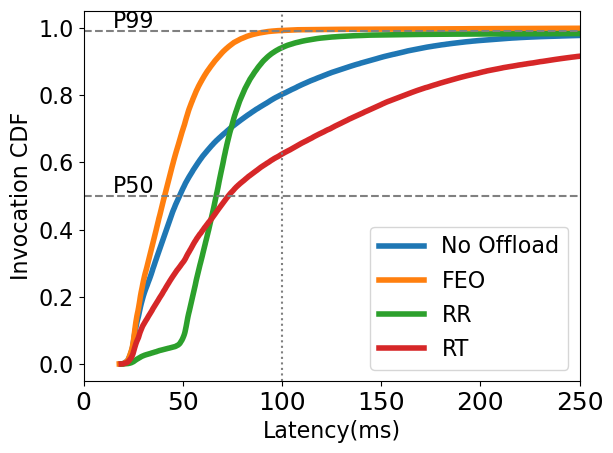

In [47]:

def get_arr(path):
    files = os.listdir(path)
    final_arr = np.array([])
    for file in files:
        if 'lats' not in file:
            continue
        fn = f'{path}{file}'
        try:
            df = pd.read_csv(fn, header=None)
            final_arr = np.hstack((final_arr, df[0].values))
        except:
            continue


    return final_arr


fig, ax = plt.subplots()
sites = range(12)
# sites = [9]

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//base/site{i}/drone_results/')
    arrs.append(arr)
base = np.hstack(arrs)
plot_cdf(base, ax)
yvals = group_by_pctls(base, pctls)
# ax.plot(yvals[:-1], marker='v', color='C0')

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//federated/site{i}/drone_results/')
    arrs.append(arr)
fed = np.hstack(arrs)
plot_cdf(fed, ax)
yvals = group_by_pctls(fed, pctls)
# ax.plot(yvals[:-1], marker='v', color=polcols2['federated'])

# arrs = []
# for i in sites:
#     arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//epoch/site{i}/drone_results/')
#     arrs.append(arr)
# epoch = np.hstack(arrs)
# plot_cdf(epoch, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//roundrobin/site{i}/drone_results/')
    arrs.append(arr)
rr = np.hstack(arrs)
plot_cdf(rr, ax)

arrs = []
for i in sites:
    arr = get_arr(f'../feodata/drone/debug/diffc-2c-test//roundrobinlatency/site{i}/drone_results/')
    arrs.append(arr)
rt = np.hstack(arrs)
plot_cdf(rt, ax)
yvals = group_by_pctls(rt, pctls)
# ax.plot(yvals[:-1], marker='v', color=polcols2['roundrobinlatency'])



# ax.legend(['No Offload','FEO','EB','RR','RT'])
ax.legend(['No Offload','FEO','RR','RT'])
ax.axvline(x=100, linestyle='dotted', color='gray')

# ax.legend(['No Offload','FEDERATED','RTIME'])
# ax.axhline(100, linestyle=':', color='black')
# ax.set_xlabel('Percentiles')
# ax.set_xticks(range(4))
# ax.set_xticklabels(pctls[:-1])

ax.set_xlim(0,250)
ax.set_ylabel('Invocation CDF')
ax.set_xlabel('Latency(ms)')

ax.axhline(.99, linestyle='dashed', color='gray')
ax.axhline(.50, linestyle='dashed', color='gray')
ax.annotate('P99', (15,1))
ax.annotate('P50', (15,.51))
fig.savefig('../paper/figs/drone-eval.pdf', bbox_inches='tight')

In [69]:
## IMPORTANT: get last line from feo.log at all sites:
# grep "Local,Offload" $PWD/$policy/site$i/feo.log | tail -n1

def get_req_box(fn):
    arr = []
    with open(fn) as fh:
        lines = fh.readlines()
        for i,line in enumerate(lines):
            tokens = line.split('=')
            vals = tokens[1].split(',')
            arr.append(vals)
    return np.array(arr).astype(int)

pols = ['base', 'federated', 'roundrobin', 'roundrobinlatency', 'epoch']
path = '../feodata/drone/debug/diffc-2c-test/'
reqvals = []

argi = None
for pol in pols:
 
    fn = f'{path}/{pol}-reqs.out'
    rv = get_req_box(fn)
    reqvals.append(rv)
    if pol == 'base':
        argi = np.argsort(rv[:,0])


[Text(0, 0, '4'),
 Text(2, 0, '10'),
 Text(4, 0, '6'),
 Text(6, 0, '1'),
 Text(8, 0, '11'),
 Text(10, 0, '0'),
 Text(12, 0, '5'),
 Text(14, 0, '8'),
 Text(16, 0, '3'),
 Text(18, 0, '2'),
 Text(20, 0, '7'),
 Text(22, 0, '9')]

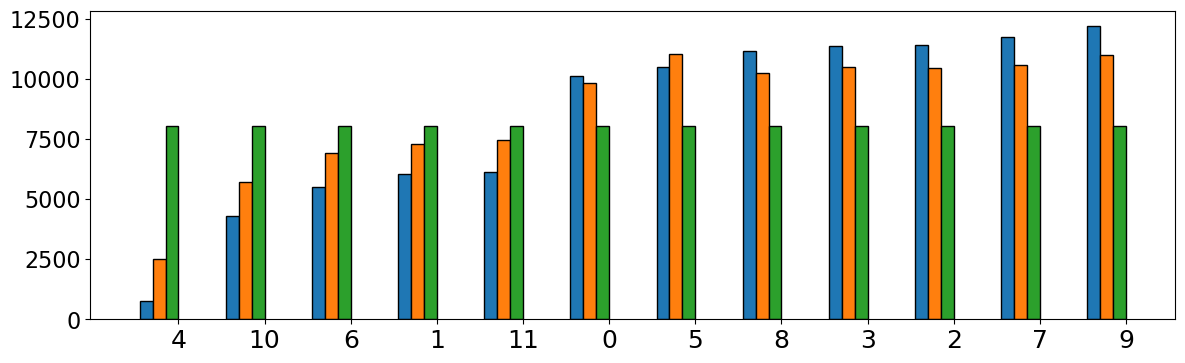

In [74]:
fig, ax = plt.subplots(figsize=(14,4))
xvals = np.arange(0,24,2)-0.75
width = 0.3
for i,pol in enumerate(pols[:3]):

    yvals = reqvals[i][:,0][argi]
    ax.bar(xvals, yvals, width=width, edgecolor='black')
    xvals += 0.3
    
ax.set_xticks(range(0,24,2))
ax.set_xticklabels(argi)

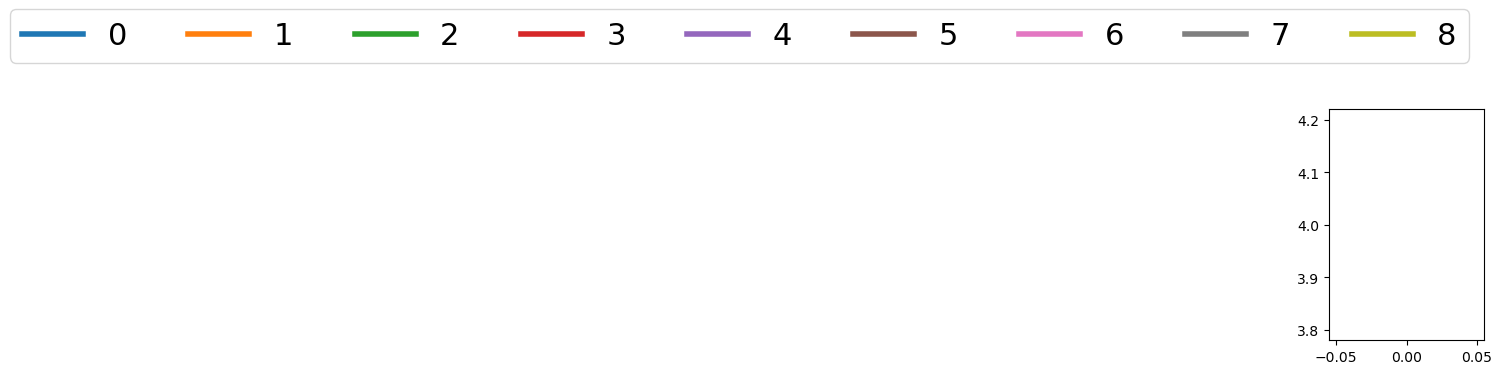

In [17]:
import numpy as np
import matplotlib.pyplot as plt
yvals = np.random.randint(10)
fig, ax = plt.subplots(figsize=(2,3))
for i in range(9):
    ax.plot(yvals, linewidth=4)
ax.legend(range(9), ncol=9, bbox_to_anchor=(1,1.5), fontsize=22, loc=1)
fig.savefig('../paper/figs/leg.pdf', bbox_inches='tight')

# QLENTH STUDY

In [41]:
def get_lats(prof, pols):
    data = {}
    sites = [i for i in range(0,9)]
    for p in pols:
        data[p] = []
        for i in sites:
            df = pd.read_csv(f'../feodata/export_qlen_data/cluster_exp_p{prof}_{p}_m2/run_load/{p}/clabcl{i}/fiblocal-profile{prof}-p2p20ms.out', header=None)
            df['lats'] = df[0].apply(conv)
#             df['qlens'] = df[0]
#             data[p].append(df['qlens'].values)
            data[p].append(df['lats'].values)
    
    return data
def conv(x):
    valstr = x.strip()
    if valstr.endswith('ms'):
        val = float(valstr[:-2])
    elif valstr.endswith('s'):
        val = 1000*float(valstr[:-1])

    return val

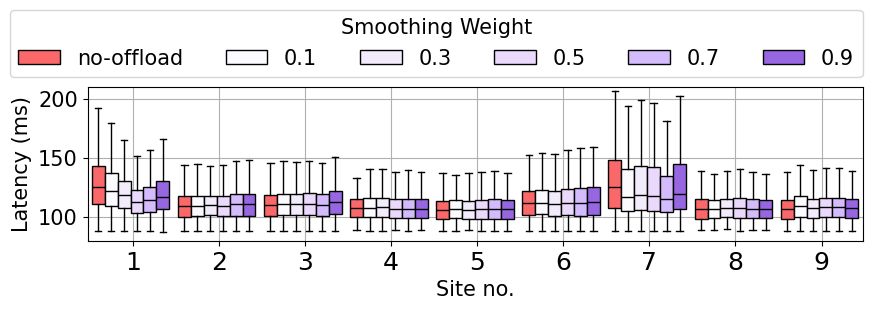

In [167]:
profs = [133,132,131,129,130]
p99 = {}
pols = ['base','federated']
for prof in profs:
    p99[prof] = {}
    data = get_lats(prof, pols)
    for i in range(9):
        
        for pol in pols:
            val = np.percentile(data[pol][i], 99.99)
            if pol not in p99[prof]:
                p99[prof][pol] = []
#             p99[prof][pol].append(val)
            p99[prof][pol].append(data[pol][i])

            
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = list(reversed(["#9667e0","#d4bbfc","#ebd9fc","#f2ebfb","#fbfaff"]))
fig,ax = plt.subplots(figsize=(10,2))

xvals = np.arange(0,36,4)
fedcolor='#7776bc'
w=0.6

legs = []
boxplot = ax.boxplot(p99[129]['base'], positions=xvals,widths=w, showfliers=False, patch_artist=True)
xvals = xvals+w
legs.append(boxplot['boxes'][0])
for patch in boxplot['boxes']:
    patch.set_facecolor('#fa686a')
    
for patch in boxplot['medians']:
    patch.set_color('black')
        
for i,p in enumerate(profs):
    #ax.bar(xvals, p99[p]['federated'], width=w, color=colors[i], edgecolor='black')
    
    boxplot = ax.boxplot(p99[p]['federated'], positions=xvals, widths=w,showfliers=False, patch_artist=True)
    legs.append(boxplot['boxes'][0])
    for patch in boxplot['boxes']:
        patch.set_facecolor(colors[i])
    for patch in boxplot['medians']:
        patch.set_color('black')
    xvals = xvals+w
    
ax.set_xticks(xvals-2)
ax.set_xticklabels(range(1,10), fontsize=18)

ax.set_ylabel('Latency (ms)')
ax.set_xlabel('Site no.')
ax.set_ylim(80,210)
ax.grid()
ax.legend(legs, ['no-offload'] + alphas, title='Smoothing Weight', ncol=6, loc=1, bbox_to_anchor=(-0.1,-0.50,1.1,2), mode='expand', borderaxespad=0.)
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/fed-smoothing-study.pdf', bbox_inches='tight')

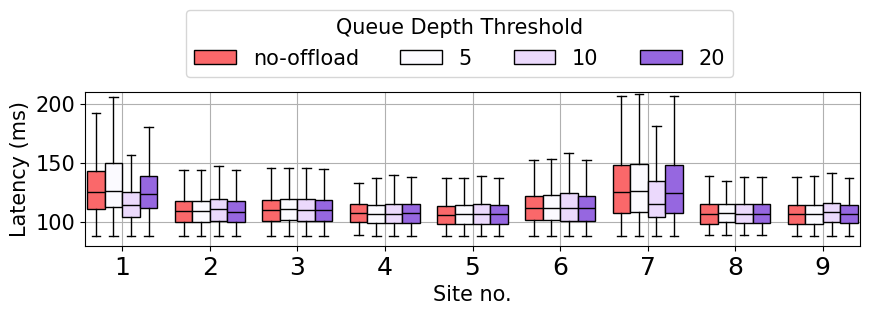

In [169]:
profs = [134,129,135]
p99 = {}
pols = ['base','federated']
for prof in profs:
    p99[prof] = {}
    data = get_lats(prof, pols)
    for i in range(9):
        
        for pol in pols:
            val = np.percentile(data[pol][i], 99.99)
            if pol not in p99[prof]:
                p99[prof][pol] = []
#             p99[prof][pol].append(val)
            p99[prof][pol].append(data[pol][i])

            
alphas = [5,10,20]
colors = list(reversed(["#9667e0","#ebd9fc","#fbfaff"]))
fig,ax = plt.subplots(figsize=(10,2))

xvals = np.arange(0,36,4)
fedcolor='#7776bc'
w=0.8

legs = []
boxplot = ax.boxplot(p99[129]['base'], positions=xvals, widths=w, showfliers=False, patch_artist=True)
xvals = xvals+w
legs.append(boxplot['boxes'][0])
for patch in boxplot['boxes']:
    patch.set_facecolor('#fa686a')
    
for patch in boxplot['medians']:
    patch.set_color('black')
        
for i,p in enumerate(profs):
    #ax.bar(xvals, p99[p]['federated'], width=w, color=colors[i], edgecolor='black')
    
    boxplot = ax.boxplot(p99[p]['federated'], positions=xvals,widths=w, showfliers=False, patch_artist=True)
    legs.append(boxplot['boxes'][0])
    for patch in boxplot['boxes']:
        patch.set_facecolor(colors[i])
    for patch in boxplot['medians']:
        patch.set_color('black')
    xvals = xvals+w
    
ax.set_xticks(xvals-2)
ax.set_xticklabels(range(1,10), fontsize=18)

ax.set_ylabel('Latency (ms)')
ax.set_xlabel('Site no.')
ax.set_ylim(80,210)
ax.grid()

ax.legend(legs, ['no-offload'] + alphas, title='Queue Depth Threshold', ncol=4, loc=1, bbox_to_anchor=(0.85,1.6))
fig.savefig('/Users/anirudh/Workspace/fededge/paper/figs/fed-qlenthresh-study.pdf', bbox_inches='tight')